# Исследование данных сервиса аренды самокатов GoFast
    
Мы рассматриваем данные сервиса аренды самокатов GoFast. Нам была передана информация о некоторых пользователях из нескольких городов, а также об их поездках. Наша задача - проанализировать данные и проверить несколько гипотез, которые могут помочь бизнесу вырасти:<br>
1. Провести исследовательский анализ данных и рассмотреть:<br>
    - Частоту встречаемости городов
    - Соотношение пользователей с подпиской и без
    - Возраст пользователей
    - Расстояние, которое пользователь преодолел за одну поездку
    - Продолжительность поездок
2. Рассчитаь выручку помесячно которую принес каждый пользователь.<br>
3. Проверить гипотезы:<br>
    - Тратят ли пользователи с подпиской больше времени на поездки
    - Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
    - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки
    - Повлияет ли обновление серверов на снижение количества обращений в техподдержку
3. Рассчитать:<br>
    - Какое минимальное количество промокодов необходимо выдать пользователям, чтобы как минимум 100 из них продлили подписку
    - Вероятность того, что из 1 млн пользователей, получивших пуш-уведомление в мобильном приложении, его откороют не более 399,5 тыс человек.<br>

В нашем распоряжении данные состоящие из 3 таблиц: 1. /datasets/users_go.csv - данные о пользователях, 2. /datasets/rides_go.csv - данные о поездках, 3. /datasets/subscriptions_go.csv - данные о подписках и тарифах для пользователей.

In [1]:
pip install scipy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import binom, norm

#### Шаг 1. Загрузка данных

In [13]:
users = pd.read_csv('/Users/denismaslov/yandex_projects/yandex/sprint4/users_go.csv')
display(users.head(10))
users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В этом датафрейме представлены данные о пользователях: user_id, Имя, Возраст, Город, тип подписки(free или ultra). В датафрейме отсутствуют пропуски.

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'distance'}>],
       [<Axes: title={'center': 'duration'}>, <Axes: >]], dtype=object)

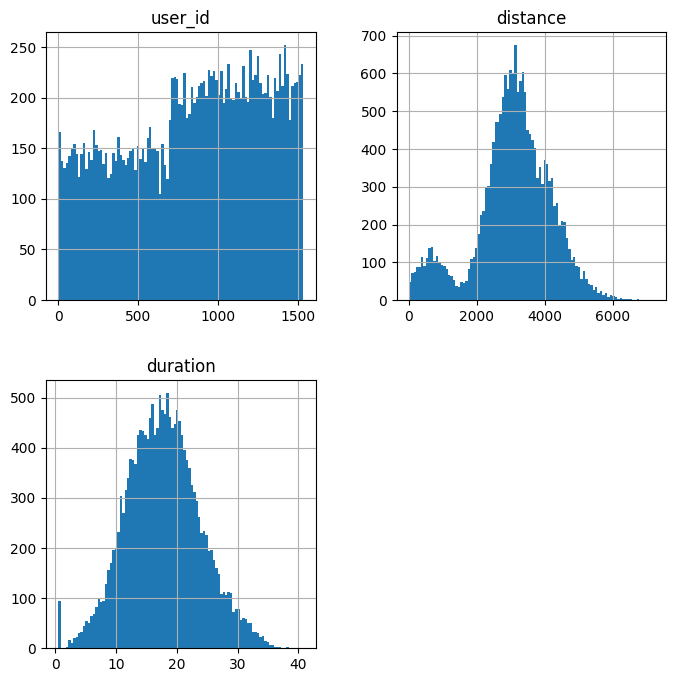

In [14]:
rides = pd.read_csv('/Users/denismaslov/yandex_projects/yandex/sprint4/rides_go.csv')
display(rides.head(10))
rides.info()
rides.hist(bins=100, figsize=(8, 8))

В этом датафрейме представлены данные о поездках: user_id, Пройденное расстояние, длительность поездки, дата поездки. В этом датафрейме отсутствуют пропуски, но формат столбца дата имеет не верный формат, мы это изменим позже. Также мы видим, что в данных о расстоянии и длительности поездки есть выбросы, их мы также исправим позже.

In [15]:
subscriptions = pd.read_csv('/Users/denismaslov/yandex_projects/yandex/sprint4/subscriptions_go.csv')
display(subscriptions.head(10))
subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В этом датафрейме представлены данные о подписках и тарифах: тип подписки, стоимость минуты поездки, стоимость начала поездки, стоимость ежемесячного платежа. Датафрейм содержит только 2 строки для двух типов подписки ultra и free, не имеет пропусков.

#### Шаг 2. Предобработка данных

В предыдущем шаге основные "проблемы" в данных мы увидели в таблице о поездках, их и исправим. В первую очередь приведем формат даты к типу даты.

In [16]:
rides.info()
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Добавляем новый столбец с номером месяца.

In [17]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
display(rides.head(10))

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


In [18]:
print('В таблице представлены данные с:', rides['date'].min(), 'по:', rides['date'].max())

В таблице представлены данные с: 2021-01-01 00:00:00 по: 2021-12-30 00:00:00


Проверим не появилось ли случайно пропусков.

In [19]:
rides.isnull().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Проверяем на уникальность поле name в таблице о пользователях

In [20]:
display(users['name'].unique())
display(users['name'].value_counts())
#userid_count = users[users['name'] == 'Мария']['user_id'].value_counts()
#print(userid_count)
print('Количество дубликатов в имени Мария', users[users['name'] == 'Мария']['user_id'].duplicated().sum())

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

name
Мария        23
Анна         22
Александр    18
Дмитрий      17
Никита       17
             ..
Матвей        3
Семен         2
Тихон         1
Радмир        1
Милана        1
Name: count, Length: 194, dtype: int64

Количество дубликатов в имени Мария 1


Само написание разных имен на мой взгляд неявных дубликатов не имеет. Некоторые имена и их user_id явно дублируются в поле name. Уберем эти дубликаты.

In [21]:
users = users.drop_duplicates(subset=['user_id'], keep='first')
display(users['name'].value_counts())
#userid_count = users[users['name'] == 'Мария']['user_id'].value_counts()
#print(userid_count)
print('Количество дубликатов в имени Мария', users[users['name'] == 'Мария']['user_id'].duplicated().sum())

name
Анна         22
Мария        22
Александр    17
Дмитрий      17
Никита       16
             ..
Матвей        3
Семен         2
Тихон         1
Радмир        1
Милана        1
Name: count, Length: 194, dtype: int64

Количество дубликатов в имени Мария 0


Тоже самое проверим в поле city.

In [22]:
display(users['city'].unique())
display(users['city'].value_counts())
#userid_city_count = users[users['city'] == 'Пятигорск']['user_id'].value_counts()
#print(userid_city_count)
print('Количество дубликатов Пятигорск', users[users['city'] == 'Пятигорск']['user_id'].duplicated().sum())

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

Количество дубликатов Пятигорск 0


В поле name дубликатов нет.

In [23]:
users.isnull().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

В исходных датафреймах мы сделали следующие изменения:
1. Привели формат даты к типу datetime таблицы rides
2. Добавили столбец с номером месяца в таблице rides
3. Получили информацию о том за какой период представлены данные о поездках
4. Удалили дубликаты поля name в таблице о пользователях
5. Проверили наличие дубликатов в поле city

#### Шаг 3. Исследовательский анализ данных

<Axes: >

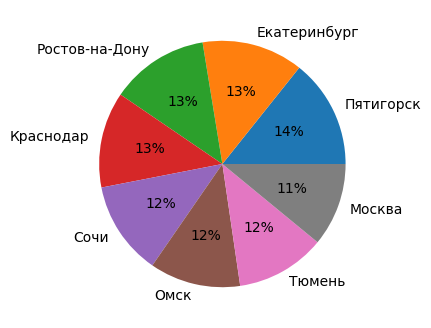

In [24]:
city_count = users['city'].value_counts()
city_count.plot(kind='pie', figsize=(4, 4), autopct='%1.0f%%', label="")
#display(city_count)

Информация по городам: мы видим что данные по городам имеют примерно одинаковые доли. Посмотрим другой тип графика.

<Axes: title={'center': 'Частота встречаемости городов'}, ylabel='city'>

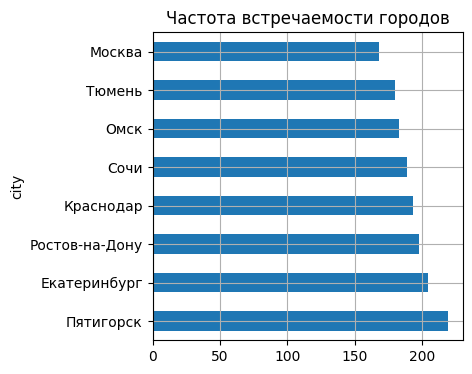

In [25]:
plt.title("Частота встречаемости городов")
plt.xlabel("Количество пользователей")
plt.ylabel("Города")

city_count.sort_values(ascending=False).plot(kind='barh', figsize=(4, 4), grid=True)



Мы видим, что с небольшим отличием, примерно все года представлены в равной степени среди данных о пользователях самокатов, что говорит о том, что сервис пользуется популярностью примерно во всех городах в равной степени. Хотя при этом Пятигорск и Екатеринбург выделяются, так как имеют больше 200 пользователей. 

<Axes: title={'center': 'Соотношение пользователей с подпиской и без подписки'}>

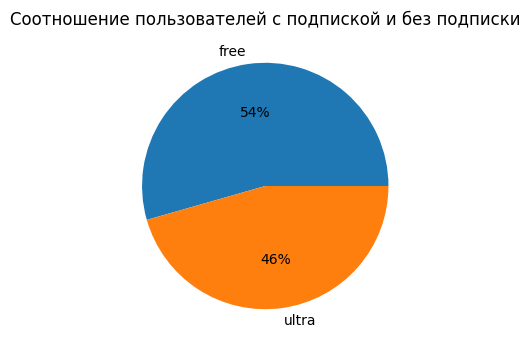

In [26]:
plt.title("Соотношение пользователей с подпиской и без подписки")

#plt.xlabel("Количество пользователей")
#plt.ylabel([])

users['subscription_type'].value_counts().plot(kind='pie', figsize=(4, 4), autopct='%1.0f%%', label="")

Соотношение пользователей с подпиской и без, примерно равно, хотя по факту количество пользователей без подписки чуть больше.

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


/Users/denismaslov/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


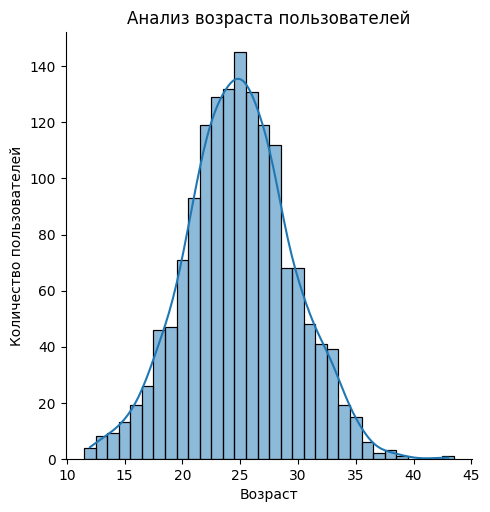

In [27]:

print(users['age'].describe())

ax = sns.displot(users['age'], discrete = True, kde = True)

plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Анализ возраста пользователей')


plt.show()

Средний возраст пользователей 25 лет. По графику видно, что возраст нормально распределен относительно среднего возраста 25 лет. Самый молодой пользователь имеет возраст - 12лет, самый возрастной - 43 года.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


/Users/denismaslov/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


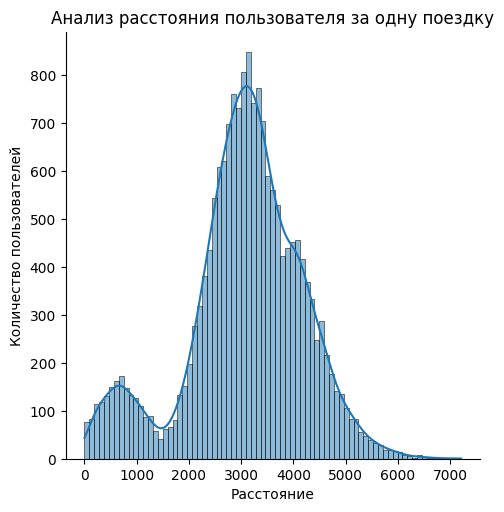

In [28]:
#distance_count = rides['distance'].mean().round()
#print(f"Средний расстояние, пройденное пользователем: {distance_count}")
#sns.kdeplot(rides['distance'])

print(rides['distance'].describe())

ax = sns.displot(rides['distance'], discrete = False, kde = True)

plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')
plt.title('Анализ расстояния пользователя за одну поездку')


plt.show()

На графике мы видим, что расстояние, которое преодолевает пользователь за одну поездку нормально распределены. Основная часть пользователь проезжает примерно 3133 м, при этом среднее расстояние равно 3070 м. На этот показатель оказывает влияние группа пользователей проезжающих совсем малое расстояние до 1 км. Природу этих малых расстояний стоит прояснить подробнее.

In [29]:
#rides = rides.query('distance >= 1200')


In [30]:
#distance_count = rides['distance'].mean().round()
#print(f"Средний расстояние, пройденное пользователем: {distance_count}")
#sns.kdeplot(rides['distance'])

Теперь мы видим, что график имеет форму нормального распредлеления. Средний пробег самоката за одну поездку состовляет 3307 м.

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


/Users/denismaslov/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


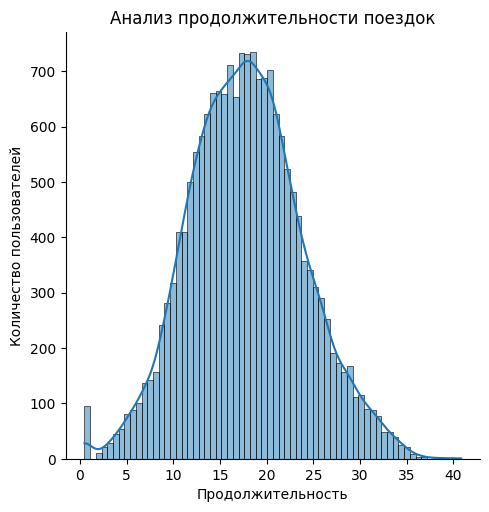

In [31]:
#duration_count = rides['duration'].mean().round()
#print(f"Средняя длительность поездки пользователя: {duration_count}")
#sns.kdeplot(rides['duration'])

print(rides['duration'].describe())

ax = sns.displot(rides['duration'], discrete = False, kde = True)

plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей')
plt.title('Анализ продолжительности поездок')


plt.show()

Средняя длительность поездки пользователя составляет 17,8 мин. На графике мы также видим выбросы в районе длительности равной 0, что странно, получается пользователь взял самокат, и тут же завершил аренду. С этим необходимо разобраться, посмотрим эти данные.

In [32]:
zero_duration = rides.query('duration < 1')
print(zero_duration.head(10))

      user_id     distance  duration       date  month
6531      701  4196.445201       0.5 2021-08-31      8
6570      704  4830.824371       0.5 2021-10-14     10
6680      712  4684.004397       0.5 2021-03-04      3
6695      713  5215.642710       0.5 2021-02-25      2
6768      718  5197.436649       0.5 2021-02-11      2
6860      724  6225.520342       0.5 2021-12-16     12
6883      726  4452.491518       0.5 2021-03-01      3
7018      735  4406.954812       0.5 2021-04-13      4
7160      745  5286.167732       0.5 2021-08-17      8
7364      760  4881.391865       0.5 2021-08-29      8


Как мы можем увидеть из таблицы, наблюдается странные аномалии в данных, пользователь тратит на поездку всего пол минуты, но при этом проезжает в районе 5 км. Природу этой аномалии необходимо выснить, либо имел место технический сбой в системе, либо данные повреждены. Удалим их.

In [33]:
rides = rides.query('duration >= 1')

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64


/Users/denismaslov/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


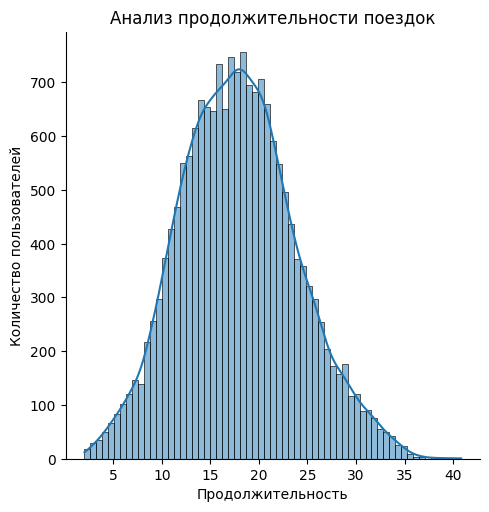

In [34]:
#duration_count = rides['duration'].mean().round()
#print(f"Средняя длительность поездки пользователя: {duration_count}")
#sns.kdeplot(rides['duration'])

print(rides['duration'].describe())

ax = sns.displot(rides['duration'], discrete = False, kde = True)

plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей')
plt.title('Анализ продолжительности поездок')


plt.show()

In [35]:
users.info()
rides.info()
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 772.3 KB
<class 'panda

Теперь средняя продолжительность поездки также состовляет 17,9 мин, график показывает нормальное распределение.

#### Шаг 4. Объединение данных

Присоеденим к таблице с данными о поездках, таблицу с данными о пользователях по столбцу user_id и выведем данные получившигося датафрейма.

In [36]:
user_rides = rides.merge(users, on='user_id', how='left', indicator=True)
display(user_rides.head(10))
user_rides.info()

,user_id,distance,duration,date,month,name,age,city,subscription_type,_merge
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,both
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,both
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,both
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,both
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,both
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,both
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,both
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,both
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,both
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,both


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int32         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   _merge             17973 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(2), int32(1), int64(2), object(3)
memory usage: 1.2+ MB


In [37]:
user_rides.isnull().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
_merge               0
dtype: int64

Теперь к получившимуся датафрейму присоеденим таблицу с данными о подписках.

In [38]:
user_rides_sub = user_rides.merge(subscriptions, on='subscription_type', how='left')
display(user_rides_sub.head(10))
user_rides_sub.info()

,user_id,distance,duration,date,month,name,age,city,subscription_type,_merge,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,both,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,both,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,both,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,both,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,both,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,both,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,both,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,both,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,both,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,both,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int32         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   _merge             17973 non-null  category      
 10  minute_price       17973 non-null  int64         
 11  start_ride_price   17973 non-null  int64         
 12  subscription_fee   17973 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(2), int32(1), int6

In [39]:
user_rides_sub.isnull().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
_merge               0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Самая большая таблица rides с информацией о поездках пользователе до обьединения содержала 17973 строки, после обьединения общая таблица содержит также 17973 строки, значит мы ничего не потеряли.

Разделим получившийся датафрейм на 2, пользователи с подпиской и без.

In [40]:
# Создание датафрейма с данными о пользователях без подписки
users_no_subscription = user_rides_sub[user_rides_sub['subscription_type'] == 'free'].copy()
users_no_subscription = users_no_subscription.reset_index(drop=True)

# Создание датафрейма с данными о пользователях с подпиской
users_subscription = user_rides_sub[user_rides_sub['subscription_type'] == 'ultra'].copy()
users_subscription = users_subscription.reset_index(drop=True)

display(users_no_subscription.head(10))
users_no_subscription.info()
display(users_subscription.head(10))
users_subscription.info()

,user_id,distance,duration,date,month,name,age,city,subscription_type,_merge,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,both,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,both,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,both,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,both,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,both,8,50,0
5,700,4342.002254,22.368009,2021-02-23,2,Айдар,22,Омск,free,both,8,50,0
6,700,3798.334905,18.243756,2021-03-03,3,Айдар,22,Омск,free,both,8,50,0
7,700,2984.551206,15.424899,2021-04-09,4,Айдар,22,Омск,free,both,8,50,0
8,700,3360.107141,16.765497,2021-06-12,6,Айдар,22,Омск,free,both,8,50,0
9,700,2567.543847,11.312160,2021-06-23,6,Айдар,22,Омск,free,both,8,50,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11473 entries, 0 to 11472
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   distance           11473 non-null  float64       
 2   duration           11473 non-null  float64       
 3   date               11473 non-null  datetime64[ns]
 4   month              11473 non-null  int32         
 5   name               11473 non-null  object        
 6   age                11473 non-null  int64         
 7   city               11473 non-null  object        
 8   subscription_type  11473 non-null  object        
 9   _merge             11473 non-null  category      
 10  minute_price       11473 non-null  int64         
 11  start_ride_price   11473 non-null  int64         
 12  subscription_fee   11473 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(2), int32(1), int6

,user_id,distance,duration,date,month,name,age,city,subscription_type,_merge,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,both,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,both,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,both,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,both,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,both,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,both,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,both,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,both,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,both,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,both,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int32         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   _merge             6500 non-null   category      
 10  minute_price       6500 non-null   int64         
 11  start_ride_price   6500 non-null   int64         
 12  subscription_fee   6500 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(2), int32(1), int64(

#### Шаг 5. Подсчёт выручки

Для начала создаем датафрейм с агрегированными данными о поездках, сгруппированных по пользователю и месяцу, который включает саммарное расстояние, количество поездок, суммарное время использования. Также перенесем в этот датафрейм столбцы с информацией о подписках. Переименуем столбцы с агрегированными данными для наглядности в  total_distance, total_duration, total_trips. Округлим значения агрегированных данных.

In [41]:
user_rides_sub['distance'] = np.ceil(user_rides_sub['distance'])
user_rides_sub['duration'] = np.ceil(user_rides_sub['duration'])

data_aggregated = user_rides_sub.groupby(['user_id', pd.Grouper(key='month')]).agg({'distance': 'sum', 'duration': 'sum', 'user_id': 'count', \
        'subscription_type': 'first', 'minute_price': 'first', 'start_ride_price': 'first', 'subscription_fee': 'first',})

data_aggregated = data_aggregated.rename(columns={'distance': 'total_distance', 'duration': 'total_duration', 'user_id': 'total_trips'})

data_aggregated = data_aggregated.reset_index()
#data_aggregated['total_distance'] = np.ceil(data_aggregated['total_distance'])
#data_aggregated['total_duration'] = np.ceil(data_aggregated['total_duration'])

display(data_aggregated.head(10))

,user_id,month,total_distance,total_duration,total_trips,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7028.0,42.0,2,ultra,6,0,199
1,1,4,755.0,7.0,1,ultra,6,0,199
2,1,8,6724.0,46.0,2,ultra,6,0,199
3,1,10,5811.0,32.0,2,ultra,6,0,199
4,1,11,7005.0,56.0,3,ultra,6,0,199
5,1,12,6753.0,28.0,2,ultra,6,0,199
6,2,3,10190.0,63.0,3,ultra,6,0,199
7,2,4,6165.0,40.0,2,ultra,6,0,199
8,2,6,3256.0,14.0,1,ultra,6,0,199
9,2,7,6781.0,48.0,2,ultra,6,0,199


Посчитаем выручку по каждому пользователю помесячно, и добавим столбец monthly_revenue с этим значением в таблицу.

In [42]:
data_aggregated['monthly_revenue'] = data_aggregated['start_ride_price'] * data_aggregated['total_trips'] + \
data_aggregated['minute_price'] * data_aggregated['total_duration'] + data_aggregated['subscription_fee']
display(data_aggregated.head(10))
data_aggregated.info()

,user_id,month,total_distance,total_duration,total_trips,subscription_type,minute_price,start_ride_price,subscription_fee,monthly_revenue
0,1,1,7028.0,42.0,2,ultra,6,0,199,451.0
1,1,4,755.0,7.0,1,ultra,6,0,199,241.0
2,1,8,6724.0,46.0,2,ultra,6,0,199,475.0
3,1,10,5811.0,32.0,2,ultra,6,0,199,391.0
4,1,11,7005.0,56.0,3,ultra,6,0,199,535.0
5,1,12,6753.0,28.0,2,ultra,6,0,199,367.0
6,2,3,10190.0,63.0,3,ultra,6,0,199,577.0
7,2,4,6165.0,40.0,2,ultra,6,0,199,439.0
8,2,6,3256.0,14.0,1,ultra,6,0,199,283.0
9,2,7,6781.0,48.0,2,ultra,6,0,199,487.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11300 entries, 0 to 11299
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11300 non-null  int64  
 1   month              11300 non-null  int32  
 2   total_distance     11300 non-null  float64
 3   total_duration     11300 non-null  float64
 4   total_trips        11300 non-null  int64  
 5   subscription_type  11300 non-null  object 
 6   minute_price       11300 non-null  int64  
 7   start_ride_price   11300 non-null  int64  
 8   subscription_fee   11300 non-null  int64  
 9   monthly_revenue    11300 non-null  float64
dtypes: float64(3), int32(1), int64(5), object(1)
memory usage: 838.8+ KB


Для корректности округления, np.ceil() применена до аггрегирования таблицы. Результаты получились чуть другими

#### Шаг 6. Проверка гипотез

6.1 Проверим, тратят ли пользователи с подпиской больше времени на поездки. Для начала рассмотрим две совокупности, пользователи с подпиской и без.

Продолжительность поездок без подписки count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64


/Users/denismaslov/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


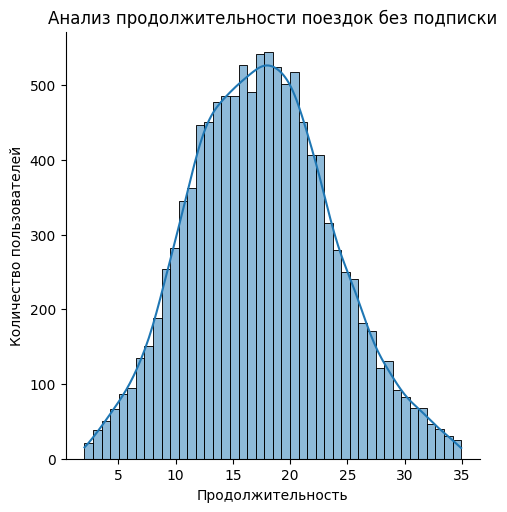

In [43]:
#sns.kdeplot(users_no_subscription['duration'])

print('Продолжительность поездок без подписки', users_no_subscription['duration'].describe())

ax = sns.displot(users_no_subscription['duration'], discrete = False, kde = True)

plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей')
plt.title('Анализ продолжительности поездок без подписки')


plt.show()

Продолжительность поездок c подпиской count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


/Users/denismaslov/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


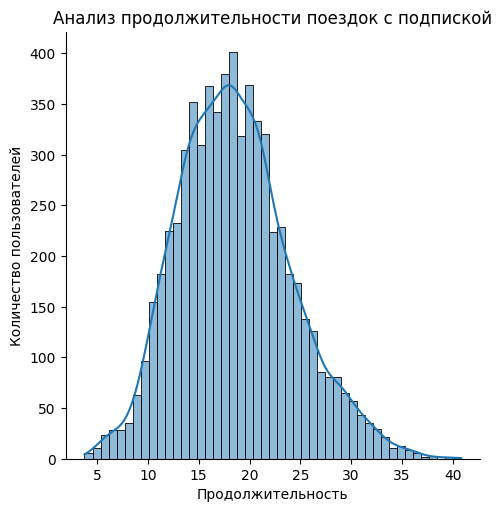

In [44]:
#sns.kdeplot(users_subscription['duration'])

print('Продолжительность поездок c подпиской', users_subscription['duration'].describe())

ax = sns.displot(users_subscription['duration'], discrete = False, kde = True)

plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей')
plt.title('Анализ продолжительности поездок c подпиской')


plt.show()

Обе совокупности имеют нормальное распределение. Вычмслим их среднее значение.

In [45]:
#print('Среднее значение продолжительности поездки без подписки:', users_no_subscription['duration'].mean().round())
#print('Среднее значение продолжительности поездки c подпиской:', users_subscription['duration'].mean().round())

Среднее значение продолжительности поездки для пользователей с подпиской выше чем пользователей без нее. Проверим эту гипотезу. За нулевую гипотезу возьмем то что совокупности равны, а следовательно нет разницы, с подпиской пользователи или без. За альтернативную гипотезу возьмем то что среднее значение совокупности пользователей без подписки меньше, чем среднее значение совокупности пользователей с подпиской. 

In [46]:
alpha = 0.05
results = st.ttest_ind(users_no_subscription['duration'], users_subscription['duration'], alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.704468074453899e-28
Отвергаем нулевую гипотезу


Следовательно среднее значение продолжительности поездки для пользователей с подпиской выше чем пользователей без нее

6.2 Проверим, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров. Рассмотрим совокупность пройденного расстояния из таблицы для пользователей с подпиской. 

Дистанция поездок c подпиской count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


/Users/denismaslov/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


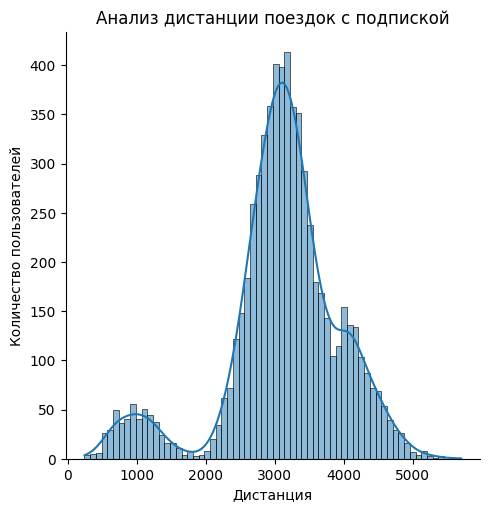

In [47]:
#users_subscription.hist('distance', bins=100, figsize=(8, 4))
#sns.kdeplot(users_subscription['distance'])

print('Дистанция поездок c подпиской', users_subscription['distance'].describe())

ax = sns.displot(users_subscription['distance'], discrete = False, kde = True)

plt.xlabel('Дистанция')
plt.ylabel('Количество пользователей')
plt.title('Анализ дистанции поездок c подпиской')


plt.show()

Совукупность имеет нормальное распределение. Среднее значение дистанции поездок пользователей 3115 м. За нулевую гипотезу возьмем то что среднее значение генеральной совокупности равно 3130 метров. За альтернативную гипотезу возьмем что пользователи с подпиской за одну сессию проезжают больше 3130.



In [48]:
optimal_distance = 3130

alpha = 0.05

results = st.ttest_1samp(users_subscription['distance'], optimal_distance, alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Следовательно, расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров.

6.3 Проверим, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сначала подготовим датафрейм с группировкой по месяцам и типу подписки и вычислим суммарную выручку. Разделим данные на 2 группы, с подпиской и без.

In [49]:
revenue_subscription = data_aggregated[data_aggregated['subscription_type'] == 'ultra']['monthly_revenue']
revenue_no_subscription = data_aggregated[data_aggregated['subscription_type'] == 'free']['monthly_revenue']
#display(revenue_subscription.head(10))
#display(revenue_no_subscription.head(10))
print(len(revenue_subscription))
print(len(revenue_no_subscription))

4533
6767


Проверим гипотезу. За нулевую гипотезу возьмем то что помесячная выручка от пользователей с подпиской по месяцам роавна выручке от пользователей без подписки. За альтернативную гипотезу возьмем то что выручка с подпиской выше чем выручка без подписки.

In [50]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу
results = st.ttest_ind(revenue_subscription, revenue_no_subscription, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


Так как не получилось отвергнуть нулевую гипотезу, то можно сделать вывод о том, что подписка не влияет на размер месячной выручки. 

6.4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?<br>
Ответ на вопрос 6.4: Если нам необходимо проанализировать количество обращений пользователя до обновления и после него, нам понадобится тест о равенстве средних для зависимых (парных) выборок, или метод scipy.stats.ttest_rel(). Ему достаточно передать 2 параметра, набор данных до и после обновления. Оба набора должны быть одинаковыми по размеру и иметь одинаковый порядок - k-е число в первом наборе должно соответствовать k-му числу во втором наборе отражающим одно и тоже измерение до и после обновления.

#### Шаг 7. Распределения

7.1 Построим график распределения и вычислим минимальное количество промокодов, необходимых для того чтобы минимум 100 пользователей продлили подписку с вероятностью минимум 5%. 

Минимальное количество промокодов, необходимое для продления подписки минимум 100 пользователей: 1171
Вероятность выполнить план: 0.0505235199072141


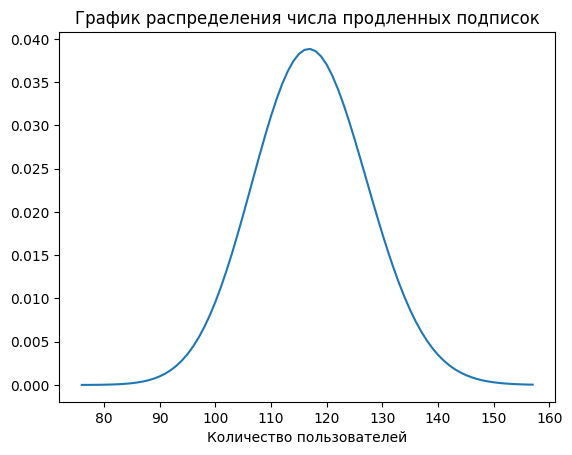

In [51]:

p = 0.1  # Вероятность продления подписки
target_prob = 0.05  # Вероятность невыполнения плана
min_N = 100
# Количество выданных промокодов N
for N in range(min_N, 2000):
#    dist = binom(N, p)
    prob = binom.cdf(min_N, N, p)
    if prob <= target_prob:
        break

mu = N * p
sigma = np.sqrt(N * p * (1 - p))


# границы промежутка, в котором будем строить аппроксимацию -
# от mu минус 4 sigma бином.распределения
# до mu плюс 4 sigma бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(mu - 4 * sigma)
right = int(mu + 4 * sigma)
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения

ax = plt.subplot(title="График распределения числа продленных подписок", xlabel="Количество пользователей")
ax.plot(x, binom.pmf(x, N, p),
	      label='вероятности биномиального распределения')


prob = binom.cdf(min_N, N-1, p)
print(f"Минимальное количество промокодов, необходимое для продления подписки минимум 100 пользователей: {N-1}")
print(f"Вероятность выполнить план: {prob}")

Как мы видим, необходимо выдать 1171 промокодов, чтобы миинмум 100 пользователей продлили подписку с вероятностью не менее 5%.

7.2 Построим график распределения и вычислим вероятность того, что уведомления откроют не более 399500 пользователей из 1 млн.

Вероятность открытия рассылки не более 399,5 тыс. пользователей: 0.15371708296369768


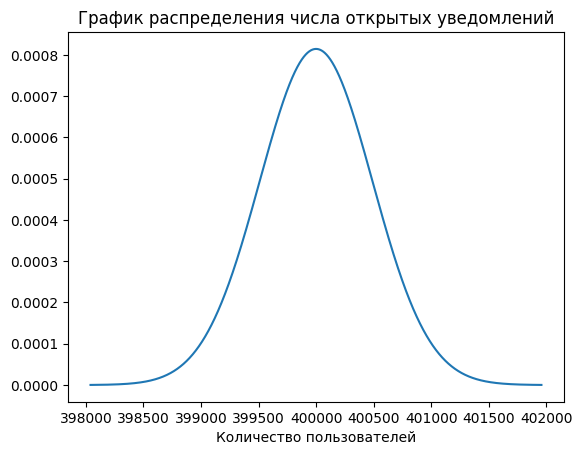

In [52]:

# задаём параметры биномиального распределения
n = 1000000
p = 0.4

mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# границы промежутка, в котором будем строить аппроксимацию -
# от mu минус 4 sigma бином.распределения
# до mu плюс 4 sigma бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(mu - 4 * sigma)
right = int(mu + 4 * sigma)
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot(title="График распределения числа открытых уведомлений", xlabel="Количество пользователей")
ax.plot(x, binom.pmf(x, n, p),
	      label='вероятности биномиального распределения')


prob = norm.cdf(399500, mu, sigma)
print(f"Вероятность открытия рассылки не более 399,5 тыс. пользователей: {prob}")


Вероятность того, что уведомления откроют не более 399500 пользователей из 1 млн. равна 15,37%. 

Общий вывод:<br>
Мы рассмортрели данные сервиса аренды самокатов GoFast. В данных встретились выбросы и дубликаты, был неверно задан тип столбца дата. Я очистил эти данные и удалил пропуски. Также были удалены выбросы, которые, на мой взгляд не влияют на предмет нашего исследования. Был проведен исследовательский анализ данных на прдмет:<br>
1. Информация по городам: мы видим что данные по городам имеют примерно одинаковые доли, но с небольшим отличием, примерно все города представлены в равной степени среди данных о пользователях самокатов, что говорит о том, что сервис пользуется популярностью примерно во всех городах в равной степени. Хотя при этом Пятигорск и Екатеринбург выделяются, так как имеют больше 200 пользователей.<br>
2. Соотношение пользователей с подпиской и без, примерно равно, хотя по факту количество пользователей без подписки чуть больше.<br>
3. Средний возраст пользователей 25 лет.<br>
4. Средний пробег самоката за одну поездку состовляет 3133 м.<br>
5. Средняя длительность поездки пользователя составляет 17,9 мин.<br>
Мы получили общий датафрейм содержит всю информацию о пользователях, их поездках и подписках, а также 2 датафрейма, с пользователями с подпиской и без.<br>
Посчитали выручку по каждому пользователю помесячно, и добавили столбец monthly_revenue с этим значением в таблицу.<br>
Проверили следующие гипотезы и получили результаты:<br>
1. Тратят ли пользователи с подпиской больше времени на поездки. Ответ - да.<br>
2. Расстояние, которое проезжают пользователи с подпиской за одну поездку в среднем, не превышает 3130 метров. Ответ - да.<br>
3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Ответ - нет.<br>
4. Если нам необходимо проверить гипотезу, как изменилось количество обращений пользователя до обновления и после него, нам понадобится тест о равенстве средних для зависимых (парных) выборок, или метод scipy.stats.ttest_rel().<br>
Мы посчитали, что отделу маркетинга необходимо выдать минимум 859  промокодов, чтобы минимум 100 пользователей продлили подписку с вероятностью 5%.<br>
Мы посчитали что из миллиона пользователей уведомление из рассылки откроют не более 399500 пользователей с вероятностью 15,37%.<br>
Как я уже писал ранее, стоит отдельно проанализировать природу выбросов в датафрейме о поездках, почему люди берут самокат в аренду, и тут же заканчивают аренду, и почему существует группа пользователей, которые проезжаю малое расстояние. На это могут влиять разные факторы: не умение пользоваться самокатом, разные скоростные режимы в городе, кончился заряд и т.д., но это предмет отдельного исследования. 
